# Naive Bayes on Amazon Food Review dataset

## Making predictions over amazon recommendation dataset

### Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms, mainly in Naïve Bayesian.

In the end, we hope to find a "best" **Optimal score(alpha)** for predicting the recommendation's sentiment.

### Loading the data
In order to load the data, we will use the SQLITE dataset where we will only fetch the Score and the recommendation summary. 

As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

The data will be split into an training set and a test set with a test set ratio of **0.3**

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

#Using sqlite3 Table to read te data
con=sqlite3.connect(r'D:\Machine Learning\Course Recordings\Assignments\Amazon Product review pridiction(Amazon Fine Food Reviews)\amazon-fine-food-reviews\database.sqlite')

filtered_data = pd.read_sql_query("""
SELECT Score,Text
FROM Reviews
WHERE Score != 3
""", con)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

actual_score=filtered_data['Score']

filtered_data['Score']=filtered_data['Score'].apply(lambda x :'negatiave' if x <3 else 'positive')


In [2]:
### Taking Random data instead of complete dataset.
filtered_data_sample=filtered_data.sample(40000, replace=True)

In [3]:
filtered_data_sample.head(5)

,Score,Text
478770,positive,I love this stuff having grown up in Hong Kong...
210686,positive,"So far, of all the decaf Kcups we have tried, ..."
149016,positive,Oh my goodness.. This is indeed the best garli...
309285,positive,...it would not dissolve fully. Product from ...
46740,positive,This is a blend of beans from 3 regions and 3 ...


In [4]:
filtered_data_sample['Score'].value_counts()

positive     33829
negatiave     6171
Name: Score, dtype: int64

## Preprocessing the data

In [5]:
"""
# import nltk
stemmer = PorterStemmer()
from nltk.corpus import stopwords

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    #tokens = [word for word in tokens if word not in stopwords.words('english')]
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)
"""

'\n# import nltk\nstemmer = PorterStemmer()\nfrom nltk.corpus import stopwords\n\ndef stem_tokens(tokens, stemmer):\n    stemmed = []\n    for item in tokens:\n        stemmed.append(stemmer.stem(item))\n    return stemmed\n\ndef tokenize(text):\n    tokens = nltk.word_tokenize(text)\n    #tokens = [word for word in tokens if word not in stopwords.words(\'english\')]\n    stems = stem_tokens(tokens, stemmer)\n    return \' \'.join(stems)\n\nintab = string.punctuation\nouttab = "                                "\ntrantab = str.maketrans(intab, outtab)\n'

In [6]:
import re
import nltk
import string 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop=set(stopwords.words('english')) # set of stop words in english
sno=nltk.stem.SnowballStemmer('english') # initilizing the snowballstemmer


def cleanhtml(sentance): # function to clean th word of any html tag<>
    cleaner=re.compile('<.*?>')
    cleantext=re.sub(cleaner,' ',sentance)
    return cleantext

def cleanpunc(sentance): # function to clean punctuation or special charactor
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentance)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('******************************')
print(sno.stem('tasty'))

{'haven', 'out', 'over', "isn't", 'didn', 'for', "that'll", 'about', 'both', 'hers', 'themselves', 'than', 'he', 'yours', 'their', 'was', 'through', 're', "aren't", "hasn't", 'them', 'be', "mustn't", 'before', 'during', 'more', 'from', 'hasn', 'itself', 'against', 'but', "should've", 'o', 'between', 'not', 'being', 've', 'these', "needn't", 'does', 'all', 'hadn', 'his', 'you', 'myself', 'when', 'its', 'needn', 'y', 'himself', 'those', 'were', 'that', 'll', 'other', 'should', 'me', 'mustn', 'how', 'don', 'while', 'won', 'wouldn', 'further', 'up', "doesn't", 'isn', "wouldn't", 'wasn', 'had', 'she', 'above', 'which', 'again', 'few', 'i', 'yourself', 'whom', 'down', 'now', 'no', 'why', 'having', "didn't", "weren't", 'ma', 'then', "don't", 'nor', 'has', 'by', 'some', 'an', 'my', 'ourselves', 'who', 'your', 'our', 'will', 'ours', 'this', 'what', 'doing', 'him', 'm', 'because', 'doesn', 'to', 'as', 'own', 'under', 'yourselves', 'd', 'at', "wasn't", 'her', 's', 'been', "you've", 'are', "should

In [7]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in filtered_data_sample['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (filtered_data_sample['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(filtered_data_sample['Score'].values)[i] == 'negatiave':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [8]:
filtered_data_sample['CleanedText']=final_string

In [9]:
# Decoding 

filtered_data_sample['CleanedText'] = [i.decode() for i in filtered_data_sample['CleanedText']]

In [10]:
#filtered_data_sample.drop('Cleaned_text',axis=1,inplace=True)

filtered_data_sample.head(5)

,Score,Text,CleanedText
478770,positive,I love this stuff having grown up in Hong Kong...,love stuff grown hong kong british coloni ate ...
210686,positive,"So far, of all the decaf Kcups we have tried, ...",far decaf kcup tri favorit wish automat order ...
149016,positive,Oh my goodness.. This is indeed the best garli...,good inde best garlic season made first becam ...
309285,positive,...it would not dissolve fully. Product from ...,would dissolv fulli product local groceri diss...
46740,positive,This is a blend of beans from 3 regions and 3 ...,blend bean region differ roast one contain pro...


In [11]:
Text=filtered_data_sample['CleanedText']
Score=filtered_data_sample['Score']

### Splitting the data

In [13]:
#BoW 

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(Text)

In [16]:
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
#X_1, X_test, y_train, y_test = train_test_split(Text, Score, test_size=0.3, random_state=0)

X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_counts,Score, test_size=0.3, random_state=0)

In [17]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

## Applying Bernoulli Naïve Bayes learning method on Bag Of Words

In [148]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

NB_List=np.linspace(.0001,.001,5)
for i in NB_List:
    
    NB = BernoulliNB(i)

    # fitting the model on crossvalidation train
    NB.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = NB.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for Alpha = %.4f is %d%%' % (i, acc))
    
NB = BernoulliNB(.0001)
NB.fit(X_tr,y_tr)
pred = NB.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for Alpha = 1 is %d%%' % (acc))


CV accuracy for Alpha = 0.0001 is 88%

CV accuracy for Alpha = 0.0003 is 89%

CV accuracy for Alpha = 0.0006 is 89%

CV accuracy for Alpha = 0.0008 is 89%

CV accuracy for Alpha = 0.0010 is 89%

****Test accuracy for Alpha = 1 is 88%



The optimal number of neighbors is 0.0006.


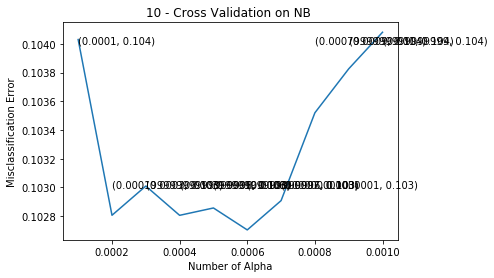

the misclassification error for each Alpha value is :  [0.104 0.103 0.103 0.103 0.103 0.103 0.103 0.104 0.104 0.104]


In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

np.set_printoptions(precision=5)

bow_myList=np.linspace(.0001,.001,10)


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for i in bow_myList:
    NB = BernoulliNB(alpha=i)
    scores = cross_val_score(NB, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = bow_myList[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %.4f.' % optimal_alpha)

# plot misclassification error vs k 
plt.plot(bow_myList, MSE)

for xy in zip(bow_myList, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Alpha')
plt.ylabel('Misclassification Error')
plt.title("10 - Cross Validation on NB ")
plt.show()

print("the misclassification error for each Alpha value is : ", np.round(MSE,3))

In [153]:

NB_optimal = BernoulliNB(alpha=optimal_alpha)

# fitting the model
NB_optimal.fit(X_tr, y_tr)

# predict the response
pred_bow = NB_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred_bow) * 100
print('\nThe accuracy of the NB classifier for alpha = %.4f is %f%%' % (optimal_alpha, acc))


The accuracy of the NB classifier for alpha = 0.0006 is 88.800000%


## Observation:

As we noticed , we have got optimal Alpha for Naive Bayes which indicates Hyper-paramter or Laplace Smooth at 0.0006 
is closer to 89% of Accuracy (Classified) and 11% are Mis-classified.

For given train data we have estimated 89% of accuracy on Test data using BagOfWords vectorizer on Naive Bayes (NB). 


## Important features which are +Ve and -Ve

In [21]:
## Finding top features from Bag Of Words
import numpy as np
neg_class_prob_sorted = NB_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = NB_optimal.feature_log_prob_[1, :].argsort()

print('Negative Words Scoring **************\n')
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10])) # np.take(arr, indices, axis=3(optional)) it returns ndarray (Ni…, Nj…, Nk…)
print('\n')
print('Positive Words Scoring **************\n')
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))


Negative Words Scoring **************

['aaaaaaarrrrrggghhh' 'nytim' 'nystatin' 'nylon' 'nyla' 'nye' 'nyc'
 'oakbrook' 'nyabon' 'nuwara']


Positive Words Scoring **************

['aaaaaaarrrrrggghhh' 'presen' 'preservat' 'preset' 'preson' 'pressiez'
 'esb' 'erythurb' 'presso' 'erythitol']


## F1- score,Precision, Recall

In [154]:
from sklearn import metrics
print(metrics.classification_report(y_test, pred_bow, target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.72      0.50      0.59      1951
   negative       0.91      0.96      0.94     10049

avg / total       0.88      0.89      0.88     12000



### Obervation:
Using Metrics from sklearn , as we notices above measurements which reprasents f1-Score which closer to 86% , recall is 87% ,Precision is 86% and Accuracy is closer to 87%.

As we observed , For given training set using BagOfWord vectiorization in Naive Bayes, we got 87% accuracy on test set.

Using **Bernoulli Naïve Bayes learning method on Naive Bayes**, we got optimal Alpha which indicates hypermeter would closer to **0.0001** .

Let's focus on confusion matrix of this model, which predicts TP,TN,FP,FN on a diagonals on the Matrix. 


## Confusion Matrix

In [117]:
confusion_matrix=cm_BoW
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('\n')

print('TPR = ',TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('\n')

print('TNR = ',TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('\n')

print('Precision = ',PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print('\n')

print('NPV(Negative Predictive Value) = ',NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print('\n')

print('FPR = ',FPR)
# False negative rate
FNR = FN/(TP+FN)
print('\n')
print('FNR = ',FNR)
# False discovery rate
print('\n')
FDR = FP/(TP+FP)

print('FDR = ',FDR)
print('\n')
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('Accuracy = ',ACC)



TPR =  [0.41 0.98]


TNR =  [0.98 0.41]


Precision =  [0.78 0.89]


NPV(Negative Predictive Value) =  [0.89 0.78]


FPR =  [0.02 0.59]


FNR =  [0.59 0.02]


FDR =  [0.22 0.11]


Accuracy =  [0.89 0.89]


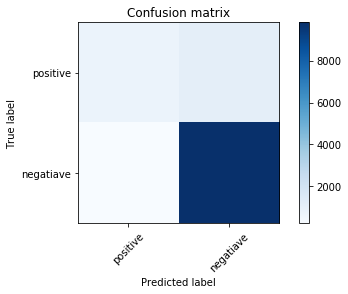

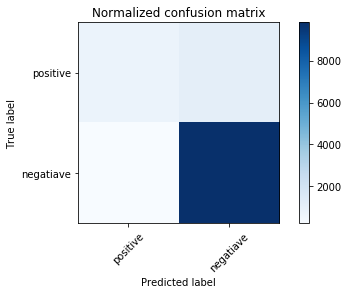

In [116]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm_BoW, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(Score)))
    plt.xticks(tick_marks, set(Score), rotation=45)
    plt.yticks(tick_marks, set(Score))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm_BoW = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

## Naive Bayes Classification using TF-IDF vector

In [26]:
# tif-idf

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

final_tf_idf = tf_idf_vect.fit_transform(Text)



In [28]:
## Splitting the data into Train and Test

from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
#X_1, X_test, y_train, y_test = train_test_split(Text, Score, test_size=0.3, random_state=0)

X_11, X_test, y_11, y_test = cross_validation.train_test_split(final_tf_idf,Score, test_size=0.3, random_state=0)

## Split only train data into Train and test for Cross validation .

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_11, y_11, test_size=0.3)



## Applying Bernoulli Naïve Bayes learning method on TF-IDF

In [136]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

np.set_printoptions(precision=5)

myList=np.linspace(.0001,.001,10)

for i in myList :
    
    
    NB = BernoulliNB(i)

    # fitting the model on crossvalidation train
    NB.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred_tfidf = NB.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred_tfidf, normalize=True) * float(100)
    print('\nCV accuracy for Alpha = %.4f is %d%%' % (i, acc))
    
NB = BernoulliNB(.0001)
NB.fit(X_tr,y_tr)
pred_tfidf = NB.predict(X_test)
acc = accuracy_score(y_test, pred_tfidf, normalize=True) * float(100)
print('\n****Test accuracy for Alpha = .0001 is %d%%' % (acc))


CV accuracy for Alpha = 0.0001 is 88%

CV accuracy for Alpha = 0.0002 is 89%

CV accuracy for Alpha = 0.0003 is 89%

CV accuracy for Alpha = 0.0004 is 89%

CV accuracy for Alpha = 0.0005 is 89%

CV accuracy for Alpha = 0.0006 is 89%

CV accuracy for Alpha = 0.0007 is 89%

CV accuracy for Alpha = 0.0008 is 89%

CV accuracy for Alpha = 0.0009 is 89%

CV accuracy for Alpha = 0.0010 is 89%

****Test accuracy for Alpha = .0001 is 88%



The optimal number of neighbors is 0.0006.


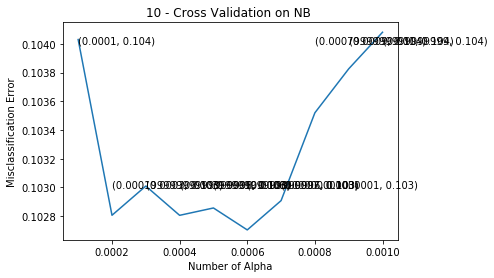

the misclassification error for each Alpha value is :  [0.104 0.103 0.103 0.103 0.103 0.103 0.103 0.104 0.104 0.104]


In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

np.set_printoptions(precision=5)

myList=np.linspace(.0001,.001,10)


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for i in myList:
    NB = BernoulliNB(alpha=i)
    scores = cross_val_score(NB, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = myList[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %.4f.' % optimal_alpha)

# plot misclassification error vs k 
plt.plot(myList, MSE)

for xy in zip(myList, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Alpha')
plt.ylabel('Misclassification Error')
plt.title("10 - Cross Validation on NB ")
plt.show()

print("the misclassification error for each Alpha value is : ", np.round(MSE,3))

In [145]:
# ============================== NaiveBayes with Alpha = optimal_Alpha ===============================================
# instantiate learning model Alpha = optimal_alpha
alpha_optimal = BernoulliNB(alpha=optimal_alpha)

# fitting the model
alpha_optimal.fit(X_tr, y_tr)

# predict the response
pred_tfidf = alpha_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test,pred_tfidf) * 100
print('\nThe accuracy of the NaiveBayes classifier for alpha = %.4f is %f%%' % (optimal_k, acc))


The accuracy of the NaiveBayes classifier for alpha = 0.0006 is 88.800000%


## Observation:

As we noticed , we have got optimal Alpha for Naive Bayes which indicates Hyper-paramter or Laplace Smooth at 0.0006 
is closer to 89% of Accuracy (Classified) and 11% are Mis-classified.

For given train data we have estimated 89% of accuracy on Test data using TF-IDF vectorizer on Naive Bayes (NB). 


## Finding Important Features for +Ve and -Ve from TF-IDF vector

In [32]:
## Finding top features from TF-IDF
import numpy as np
neg_class_prob_sorted = NB_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = NB_optimal.feature_log_prob_[1, :].argsort()

print('Negative Words Scoring for Top 10 **************\n')
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[:10])) # np.take(arr, indices, axis=3(optional)) it returns ndarray (Ni…, Nj…, Nk…)
print('\n')
print('Positive Words Scoring for Top 10 **************\n')
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[:10]))


Negative Words Scoring for Top 10 **************

['aaaaaaarrrrrggghhh' 'also harder' 'also hard' 'also happili'
 'also happi' 'also happen' 'also handi' 'also havent' 'also halo'
 'also hairbal']


Positive Words Scoring for Top 10 **************

['aaaaaaarrrrrggghhh' 'alway deposit' 'alway diet' 'alway differ'
 'alway dig' 'alway disappoint' 'advantag local' 'advantag littl'
 'alway dish' 'advantag lick']


## F1- score,Precision, Recall

In [146]:
from sklearn import metrics
print(metrics.classification_report(y_test, pred_tfidf, target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.72      0.50      0.59      1951
   negative       0.91      0.96      0.94     10049

avg / total       0.88      0.89      0.88     12000



## Obervation:

Using Metrics from sklearn , as we notices above measurements which reprasents f1-Score which closer to 88% , recall is 89% ,Precision is 88% and Accuracy is closer to 89%.

As we observed , For given training set using TF-IDF vectiorization in Naive Bayes, we got 88% accuracy on test set.

Using Bernoulli Naïve Bayes learning method on Naive Bayes, we got optimal Alpha which indicates hypermeter would closer to 0.0006 .

Let's focus on confusion matrix of this model, which predicts TP,TN,FP,FN on the Matrix. 


## Confusion Matrix

In [108]:
confusion_matrix=cm
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('\n')

print('TPR = ',TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('\n')

print('TNR = ',TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('\n')

print('Precision = ',PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print('\n')

print('NPV(Negative Predictive Value) = ',NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print('\n')

print('FPR = ',FPR)
# False negative rate
FNR = FN/(TP+FN)
print('\n')
print('FNR = ',FNR)
# False discovery rate
print('\n')
FDR = FP/(TP+FP)

print('FDR = ',FDR)
print('\n')
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('Accuracy = ',ACC)



TPR =  [0.41 0.98]


TNR =  [0.98 0.41]


Precision =  [0.78 0.89]


NPV(Negative Predictive Value) =  [0.89 0.78]


FPR =  [0.02 0.59]


FNR =  [0.59 0.02]


FDR =  [0.22 0.11]


Accuracy =  [0.89 0.89]


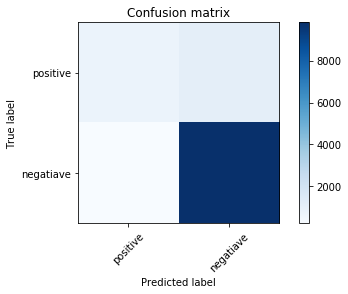

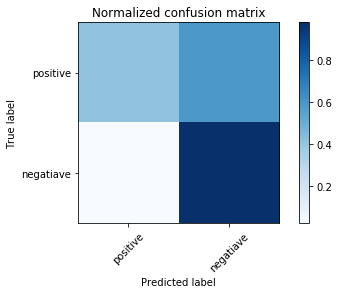

In [114]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(Score)))
    plt.xticks(tick_marks, set(Score), rotation=45)
    plt.yticks(tick_marks, set(Score))
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
      
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_tfidf)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

## Conclusion:
   **We can assume that using BagOfWords and TF-IDF vectorizer has got Accuracy is closer to 89% for Hyper-paramter    (alpa)which indicates Lapace Smooth. **
   
  **If we look at F1-score which closer to Accuracy , it implies that for given train data we accomplished 89% accuracy     on Test data **
  
  **Naive Bayes , using Bernoulli Naïve Bayes we accomplished Laplace Smooth at 0.0006 which is 
    called Optimal Hyper-parameter.**